In [1]:
import sys
sys.path.append("../library")

In [2]:
from __future__ import print_function, division
import scipy
import pandas as pd
import math
import numpy as np
from thinkbayes2 import Suite, Pmf, Pdf, Mean, MeanVar, EvalPoissonPmf, \
    MakeCdfFromList, MakeNormalPmf, MakeMixture, MakePoissonPmf, MakeExponentialPmf, MakeUniformPmf, \
    PmfProbLess, PmfProbEqual, EstimatedPdf, MakeCdfFromList, MakePmfFromList
import matplotlib.pyplot as plt
import thinkplot

In [3]:
def MakeRange(low=10, high=None, skip=10):
    """Makes a range representing possible gap times in seconds.
    low: where to start
    high: where to end
    skip: how many to skip
    Reference: https://github.com/AllenDowney/ThinkBayes/blob/master/code/redline.py#L107
    """
    if high is None:
        high = UPPER_BOUND

    return range(low, high+skip, skip)

In [4]:
# group by 'date' then calculate the gap between
def readSublineGaps(kendall_redline_path:str = 'redline.csv.gz'):
    kendall_redline_df = pd.read_csv(kendall_redline_path, compression='gzip', parse_dates=['arrival_time', 'departure_time'])
    subline_gaps = []
    for date_ in kendall_redline_df['date'].unique():
        arrival_times = kendall_redline_df[kendall_redline_df['date'] == date_][['arrival_time']]
        for i in range(len(arrival_times) - 1):
            difference = arrival_times.iloc[i+1].arrival_time - arrival_times.iloc[i].arrival_time
            subline_gaps.append(difference.seconds / 60)
    return subline_gaps

def kde_sample(sample):
    """
    sampling based on KDE
    """
    pdf = EstimatedPdf(sample)
    # reference: internal implementation of pdf.MakePmf
    low, high = min(sample), max(sample)
    n = 101
    xs = np.linspace(low, high, n)
    pmf = pdf.MakePmf(xs=xs)
    return pmf

In [5]:
def BiasPmf(pmf):
    """
    Compute Bias pmf based on observation of customer, as customer believe that what they saw ~ likelihood of happening
    """
    new_pmf = pmf.Copy()
    for x, p in pmf.Items():
        # actually doing this: p[x] * likelihood(~x)
        new_pmf.Mult(x, x)
    new_pmf.Normalize()
    return new_pmf

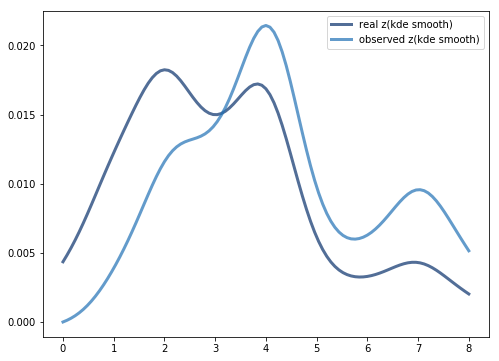

In [6]:
subline_gaps = readSublineGaps()
pmf_zsmooth = kde_sample(subline_gaps)
pmf_zbsmooth = BiasPmf(pmf_zsmooth)

# thinkplot for visualization
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Plot(pmf_zsmooth, label='real z(kde smooth)')
thinkplot.Plot(pmf_zbsmooth, label='observed z(kde smooth)')
plt.legend()
plt.show()

In [7]:
class WaitTimeCalculator(object):
    """
    calculator for waiting time.
    """
    def __init__(self, pmf_z):
        # prior of z for timeslot between trains distribution
        self.pmf_z = pmf_z
        self.pmf_zb = BiasPmf(pmf=pmf_z)
        
        self.pmf_y = self.PmfOfWaitTime(self.pmf_zb)
        self.pmf_x = self.pmf_y
        
    def PmfOfWaitTime(self, pmf_zb: Pmf):
        """
        To estimate waiting time distribution based on distribution of time between buses.
        Arguments:
            1, pmf_zb: the historical distribution of time between buses
        Return:
            distribution of waiting time of buses
        """
        metapmf = Pmf()
        for gap, prob in pmf_zb.Items():
            uniform = MakeUniformPmf(0, gap)
            metapmf.Set(uniform, prob)
        pmf_y = MakeMixture(metapmf)
        return pmf_y

average of train gap:  3.146111996710297
average of observed train gap:  4.176853693377762
average of waiting time:  2.088426846688879


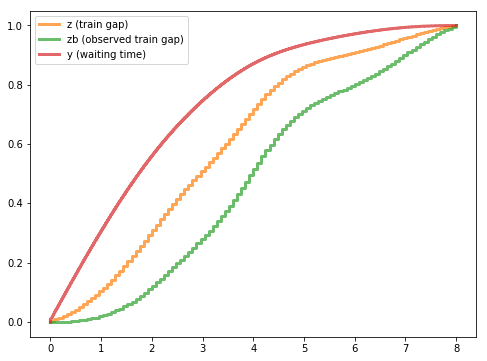

In [8]:
wtc = WaitTimeCalculator(pmf_zsmooth)

# thinkplot for visualization
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.cdf(wtc.pmf_z.MakeCdf(label='z (train gap)'), color='C1')
print("average of train gap: ", wtc.pmf_z.Mean())
thinkplot.cdf(wtc.pmf_zb.MakeCdf(label='zb (observed train gap)'), color='C2')
print("average of observed train gap: ", wtc.pmf_zb.Mean())
thinkplot.cdf(wtc.pmf_y.MakeCdf(label='y (waiting time)'), color='C3')
print("average of waiting time: ", wtc.pmf_y.Mean())
plt.legend()
plt.show()

In [9]:
def RemoveNegatives(pmf):
    leftover = pmf.Copy()
    count = 0
    for val in leftover.Values():
        if val < 0:
            pmf.Remove(val)
            count += 1
    pmf.Normalize()
    
def PredictWaitTime(pmf_zb, pmf_x):
    pmf_y = pmf_zb - pmf_x
    RemoveNegatives(pmf_y)
    return pmf_y

class Elapsed(Suite):
    """
    Elapsed time distribution
    """
    def Likelihood(self, data, hypo):
        x = hypo
        lam, k = data
        like = EvalPoissonPmf(lam * x, k)
        return like
    
class ElapsedTimeEstimator(object):
    def __init__(self, wtc, lam, num_passengers):
        self.prior_x = Elapsed(wtc.pmf_x)
        self.post_x = self.prior_x.Copy()
        # update with (lam, num_passengers) for waiting time prediction
        self.post_x.Update((lam, num_passengers))
        self.pmf_y = PredictWaitTime(wtc.pmf_zb, self.post_x)

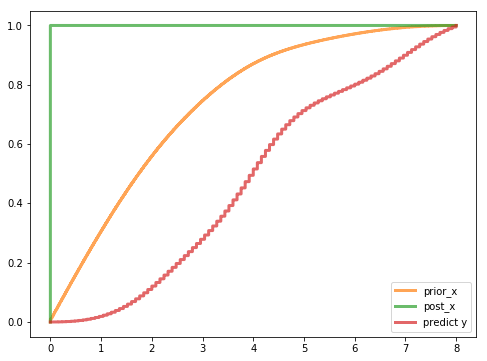

In [10]:
ete = ElapsedTimeEstimator(wtc, lam=2.0/60, num_passengers=3)

# thinkplot for visualization
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.cdf(ete.prior_x.MakeCdf(label='prior_x'), color='C1')
thinkplot.cdf(ete.post_x.MakeCdf(label='post_x'), color='C2')
thinkplot.cdf(ete.pmf_y.MakeCdf(label='predict y'), color='C3')
plt.legend()
plt.show()

In [11]:
# read k1, y, k2 for summary
def readWaitTimeAndCustomerNumber(wait_sample:str = 'wait_sample.csv'):
    wait_sample_df = pd.read_csv(wait_sample, sep=',')
    # header shouldn't be with space, only sepetor ','
    wait_sample_df['k'] = wait_sample_df.apply(lambda x: x.k1 + x.k2, axis=1)
    wait_sample_dict = dict(zip(wait_sample_df['y'].values, wait_sample_df['k2'].values))
    return wait_sample_dict

In [12]:
class ArrivalRate(Suite):
    def Likelihood(self, data, hypo):
        lam = hypo
        y, k = data
        # hypo is lam * y customer is average value, then we have k customer for waiting, how likelihood look like?
        like = EvalPoissonPmf(lam * y, k)
        return like

class ArrivalRateEstimator(object):
    def __init__(self, passenger_data):
        """
        passenger_data is list of (waiting time, customer number).
        """
        low, high = 0, 5
        n = 51
        hypos = np.linspace(low, high, n) / 60
        
        self.prior_lam = ArrivalRate(hypos)
        self.post_lam = self.prior_lam.Copy()
        for y, k2 in passenger_data.items():
            self.post_lam.Update((y, k2))

In [13]:
wait_sample_dict = readWaitTimeAndCustomerNumber()
arrival_rate_estimator = ArrivalRateEstimator(wait_sample_dict)

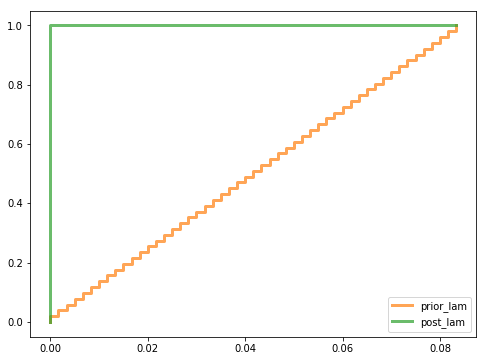

In [14]:
# thinkplot for visualization
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.cdf(arrival_rate_estimator.prior_lam.MakeCdf(label='prior_lam'), color='C1')
thinkplot.cdf(arrival_rate_estimator.post_lam.MakeCdf(label='post_lam'), color='C2')
plt.legend()
plt.show()

In [15]:
class WaitMixtureEstimator(object):
    def __init__(self, wtc:WaitTimeCalculator, are:ArrivalRateEstimator, num_passengers=15):
        self.etes = []
        self.metapmf = Pmf()
        for lam, prob in sorted(are.post_lam.Items()):
            ete = ElapsedTimeEstimator(wtc, lam, num_passengers)
            self.etes.append(ete)
            self.metapmf.Set(ete.pmf_y, prob)
        self.mixture = MakeMixture(self.metapmf)

In [16]:
mix = WaitMixtureEstimator(wtc, arrival_rate_estimator)

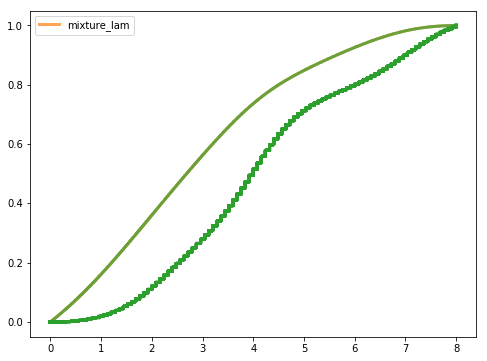

In [17]:
# thinkplot for visualization
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.cdf(mix.mixture.MakeCdf(label='mixture_lam'), color='C1')
for ete in mix.etes:
    thinkplot.cdf(ete.pmf_y.MakeCdf(), color='C2')
plt.legend()
plt.show()

# Decsion analysis
Using BiasPmf to add [1800, 2400, 300] then estimate pmf_zb via KDE

In [18]:
n = 220
gap_times = readSublineGaps()
cdf_z = MakeCdfFromList(gap_times)
# resample for z
sample_z = cdf_z.Sample(n)
pmf_z = MakePmfFromList(sample_z)

In [ ]:
cdf_zp = BiasPmf(pmf_z).MakeCdf()
cdf_zp.Sample(n)

In [ ]:
cdf_zp = BiasPmf(pmf_z).MakeCdf()
sample_zb = cdf_zp.Sample(n).append([1800, 2400, 300])
pdf_zb = EstimatePdf(sample_zb)
xs = MakeRange(low = 60)
# what's the implementation of pdf_zb MakePmf()
pmf_zb = pdf_zb.MakePmf(xs)
pmf_z = UnbiasPmf(pmf_zb)
wtc = WaitTimeCalculator(pmf_z)

In [ ]:
def ProbLongWait(num_passengers, minutes):
    ete = ElapsedTimeEstimator(wtc, lam, num_passengers)
    cdf_y = ete.pmf_y.MakeCdf()
    prob = 1 - cdf_y.Prob(minutes * 60)